In [1]:
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import folium # map rendering library

# Task 1

In [2]:
response = requests.get(
    url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M",
).text
soup = BeautifulSoup(response, 'html.parser')

title = soup.find(id="firstHeading")
print(title.string)

List of postal codes of Canada: M


In [3]:
table_contents=[]
table=soup.find("table")
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)


In [4]:
# print(table_contents)
df=pd.DataFrame(table_contents)

In [5]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [6]:
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest',
                                             'East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [7]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [8]:
df.shape

(103, 3)

# Task 2

In [9]:
geo=pd.read_csv('Geospatial_Coordinates.csv')
geo


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [10]:
geo.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)

In [11]:
df=df.merge(geo,
         on='PostalCode')

In [12]:
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


# Task 3

In [13]:
address = 'Toronto'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


## Toronto Neighborhoods Map

In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Choosing a borough to perform analysis on

In [15]:
Downtown_data = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
Downtown_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
7,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817


## Define Credentials

In [16]:
CLIENT_ID = 'PSA0D45TGDPOCKTNLSAS2DNQ2KYOOVLHKZQAPUGEIC5J54CY' # your Foursquare ID
CLIENT_SECRET = 'QXLASSUNZUMR1S0OBWY3BBTYGWO0KVGAFSAE1WR4T05V320S' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PSA0D45TGDPOCKTNLSAS2DNQ2KYOOVLHKZQAPUGEIC5J54CY
CLIENT_SECRET:QXLASSUNZUMR1S0OBWY3BBTYGWO0KVGAFSAE1WR4T05V320S


## Explore one neighborhood

In [17]:
Downtown_data.iloc[4]

PostalCode                     M5G
Borough           Downtown Toronto
Neighborhood    Central Bay Street
Latitude                    43.658
Longitude                 -79.3874
Name: 4, dtype: object

In [18]:
neigh=Downtown_data.loc[4, 'Neighborhood']
neigh

'Central Bay Street'

In [19]:
neighborhood_latitude = Downtown_data.loc[4, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Downtown_data.loc[4, 'Longitude'] # neighborhood longitude value

neighborhood_name = Downtown_data.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Central Bay Street are 43.6579524, -79.3873826.


In [20]:
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=PSA0D45TGDPOCKTNLSAS2DNQ2KYOOVLHKZQAPUGEIC5J54CY&client_secret=QXLASSUNZUMR1S0OBWY3BBTYGWO0KVGAFSAE1WR4T05V320S&v=20180605&ll=43.6579524,-79.3873826&radius=500&limit=100'

In [21]:
results = requests.get(url).json()
#results

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

<ipython-input-23-4243e3e1ab9c>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Jimmy's Coffee,Coffee Shop,43.658421,-79.385613
1,KAKA,Japanese Restaurant,43.657457,-79.384192
2,Hailed Coffee,Coffee Shop,43.658833,-79.383684
3,The Elm Tree Restaurant,Modern European Restaurant,43.657397,-79.383761
4,College Park Area,Park,43.659453,-79.383785
...,...,...,...,...
58,Mo'Ramyun,Korean Restaurant,43.656148,-79.392282
59,Pastacceria,Italian Restaurant,43.660020,-79.388188
60,Valens Restaurants,Restaurant,43.656096,-79.392839
61,Ontario Fire Fighters Memorial,Sculpture Garden,43.660335,-79.389921


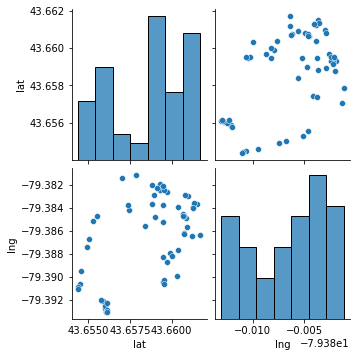

In [24]:
sns.pairplot(nearby_venues)

## Plot venues

In [25]:
# create map of Toronto using latitude and longitude values
map_venue = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venue)  
    
map_venue

## Let's do clustering based on geo location of venues

In [26]:
# Scale Data
# Save X data
X = nearby_venues.drop(columns = ['name','categories'])
scaler = StandardScaler()

nearby_venues_sc = scaler.fit_transform(X)
nearby_venues_sc

array([[-0.08126148,  0.23874025],
       [-0.515029  ,  0.62495402],
       [ 0.10404649,  0.76302417],
       [-0.54201336,  0.74209769],
       [ 0.38310168,  0.73545249],
       [-1.60715279, -0.06306409],
       [-1.65798931, -0.2533136 ],
       [ 0.38447597, -1.0648642 ],
       [-1.81400941, -0.80363798],
       [ 0.31064088,  1.23428517],
       [ 0.97268577,  0.08363078],
       [-1.50055658,  0.3604946 ],
       [-1.16376622, -1.70240863],
       [ 1.30416294,  0.77589883],
       [ 0.38944716, -0.47726103],
       [-1.85483627, -1.12554975],
       [-1.88531423, -1.19809838],
       [-1.9031402 , -1.22671814],
       [-1.37727215,  0.49112489],
       [-0.70679002,  1.38260307],
       [-1.24879521, -1.50798199],
       [ 0.80522498, -0.31851139],
       [-0.33067849,  1.44430807],
       [ 0.18210905,  0.47067388],
       [ 1.07511778,  0.95531667],
       [ 1.00860495,  0.43642458],
       [ 0.92333309,  0.53943776],
       [ 0.31380948,  1.09576065],
       [ 0.41584793,

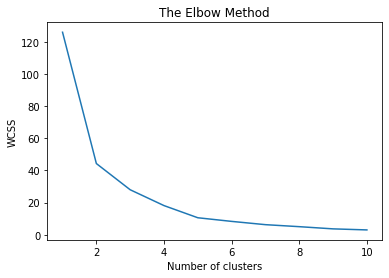

In [27]:
# Create Elbow Plot to decide number of clusters
wcss = [] 

# Iterate over different value of K to determine optimal number of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i,random_state = 123)
    kmeans.fit(nearby_venues_sc)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### from above plot, we will create 5 clusters

In [28]:
kmeans = KMeans(n_clusters = 5, random_state = 123).fit(nearby_venues_sc)


In [29]:
len(kmeans.labels_)

63

In [30]:
nearby_venues['label']=kmeans.labels_

In [31]:
nearby_venues

,name,categories,lat,lng,label
0,Jimmy's Coffee,Coffee Shop,43.658421,-79.385613,0
1,KAKA,Japanese Restaurant,43.657457,-79.384192,0
2,Hailed Coffee,Coffee Shop,43.658833,-79.383684,0
3,The Elm Tree Restaurant,Modern European Restaurant,43.657397,-79.383761,0
4,College Park Area,Park,43.659453,-79.383785,0
...,...,...,...,...,...
58,Mo'Ramyun,Korean Restaurant,43.656148,-79.392282,1
59,Pastacceria,Italian Restaurant,43.660020,-79.388188,4
60,Valens Restaurants,Restaurant,43.656096,-79.392839,1
61,Ontario Fire Fighters Memorial,Sculpture Garden,43.660335,-79.389921,4


## Lets see how the data clustered

In [32]:
nearby_venues[nearby_venues['label']==0]

,name,categories,lat,lng,label
0,Jimmy's Coffee,Coffee Shop,43.658421,-79.385613,0
1,KAKA,Japanese Restaurant,43.657457,-79.384192,0
2,Hailed Coffee,Coffee Shop,43.658833,-79.383684,0
3,The Elm Tree Restaurant,Modern European Restaurant,43.657397,-79.383761,0
4,College Park Area,Park,43.659453,-79.383785,0
9,Banh Mi Boys,Sandwich Place,43.659292,-79.381949,0
19,Silver Snail Comics,Comic Shop,43.657031,-79.381403,0
22,Ali Baba's - Yonge north of Dundas,Middle Eastern Restaurant,43.657867,-79.381176,0
23,Subway,Sandwich Place,43.659006,-79.384760,0
27,RBC Royal Bank,Bank,43.659299,-79.382459,0


In [33]:
nearby_venues[nearby_venues['label']==1]

,name,categories,lat,lng,label
8,Cafe Plenty,Café,43.654571,-79.389450,1
12,Vegetarian Haven,Vegetarian / Vegan Restaurant,43.656016,-79.392758,1
15,Gallery Sushi,Sushi Restaurant,43.654481,-79.390635,1
16,The Library Specialty Coffee,Coffee Shop,43.654413,-79.390902,1
17,Curry's Artists' Materials - Dundas St. West (...,Arts & Crafts Store,43.654373,-79.391007,1
20,Jimmy's Coffee,Café,43.655827,-79.392042,1
33,Midi Bistro,French Restaurant,43.655871,-79.392091,1
34,Arctic Bites,Ice Cream Shop,43.656085,-79.392913,1
37,Light Café 路燈咖啡,Café,43.656071,-79.393021,1
45,Omai,Japanese Restaurant,43.656006,-79.392494,1


In [34]:
nearby_venues[nearby_venues['label']==2]

,name,categories,lat,lng,label
10,Coffee Public,Coffee Shop,43.660763,-79.386184,2
13,The Yoga Sanctuary,Yoga Studio,43.661499,-79.383636,2
24,Lebanon Express,Falafel Restaurant,43.660991,-79.382976,2
25,TD Canada Trust,Bank,43.660843,-79.384886,2
26,Subway,Sandwich Place,43.660653,-79.384506,2
29,KFC,Fast Food Restaurant,43.660400,-79.383900,2
30,freshii,Salad Place,43.661286,-79.383964,2
31,Pizza Pizza,Pizza Place,43.659487,-79.385207,2
40,Colaba Junction,Indian Restaurant,43.660940,-79.385635,2
41,Second Cup,Coffee Shop,43.660770,-79.384676,2


In [35]:
nearby_venues[nearby_venues['label']==3]

,name,categories,lat,lng,label
5,Kathy's Sushi and Bento,Sushi Restaurant,43.655031,-79.386724,3
6,Rolltation,Japanese Restaurant,43.654918,-79.387424,3
11,Japango,Sushi Restaurant,43.655268,-79.385165,3
18,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684,3


In [36]:
nearby_venues[nearby_venues['label']==4]

,name,categories,lat,lng,label
7,Starbucks,Coffee Shop,43.659456,-79.390411,4
14,Subway,Sandwich Place,43.659467,-79.388249,4
21,Mercatto,Italian Restaurant,43.660391,-79.387664,4
28,Starbucks,Coffee Shop,43.659526,-79.390270,4
36,Est West Cafe,Salad Place,43.659541,-79.390637,4
39,Tim Hortons,Coffee Shop,43.659695,-79.388706,4
57,Teriyaki Experience,Restaurant,43.659884,-79.387879,4
59,Pastacceria,Italian Restaurant,43.660020,-79.388188,4
61,Ontario Fire Fighters Memorial,Sculpture Garden,43.660335,-79.389921,4
